In [0]:
import math
from IPython import display
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from tensorflow.python.data import Dataset
from sklearn import metrics
from matplotlib import cm
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving student-por.csv to student-por.csv


In [0]:
data = pd.read_csv('student-por.csv', sep=";")
y = data.G3

In [0]:
data.corr()['G3'].sort_values()

In [5]:
category_data = data.select_dtypes('object')

dummy_data = pd.get_dummies(category_data)

dummy_data['G3'] = data['G3']

dummy_data.corr()['G3'].sort_values()

higher_no           -0.332172
school_MS           -0.284294
address_R           -0.167637
internet_no         -0.150025
Mjob_at_home        -0.136778
reason_other        -0.132577
sex_M               -0.129077
reason_course       -0.098305
romantic_yes        -0.090583
guardian_other      -0.080729
schoolsup_yes       -0.066405
activities_no       -0.059791
Mjob_other          -0.059251
famsup_no           -0.059206
paid_yes            -0.054898
Fjob_services       -0.053204
famsize_GT3         -0.045016
Fjob_at_home        -0.038904
nursery_no          -0.028752
Fjob_other          -0.005301
guardian_mother     -0.004415
Pstatus_T           -0.000754
Pstatus_A            0.000754
nursery_yes          0.028752
Mjob_services        0.038447
Fjob_health          0.039142
famsize_LE3          0.045016
reason_home          0.046537
guardian_father      0.051030
paid_no              0.054898
famsup_yes           0.059206
activities_yes       0.059791
schoolsup_no         0.066405
romantic_n

In [7]:
data = data.drop(['G1', 'G2'], axis=1)
data = data[~data['G3'].isin([0, 1])]
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,13


In [0]:
def preprocess_features(data):
  selected_features = data[["failures", "Dalc", "Walc", "traveltime", "freetime", "age", "Fedu", "Medu", "studytime"]]
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(data):
  output_targets = pd.DataFrame()
  output_targets["G3"] = (data["G3"])
  return output_targets

In [9]:
training_features = preprocess_features(data.head(520))
training_features.describe()

,failures,Dalc,Walc,traveltime,freetime,age,Fedu,Medu,studytime
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,0.184615,1.473077,2.255769,1.500000,3.184615,16.590385,2.373077,2.571154,1.978846
std,0.541668,0.916161,1.299906,0.739734,0.997373,1.227300,1.096169,1.113386,0.847491
min,0.000000,1.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,3.000000,16.000000,1.000000,2.000000,1.000000
50%,0.000000,1.000000,2.000000,1.000000,3.000000,16.000000,2.000000,2.500000,2.000000
75%,0.000000,2.000000,3.000000,2.000000,4.000000,17.000000,3.000000,4.000000,2.000000
max,3.000000,5.000000,5.000000,4.000000,5.000000,22.000000,4.000000,4.000000,4.000000


In [10]:
training_targets = preprocess_targets(data.head(520))
training_targets.describe()

,G3
count,520.000000
mean,12.275000
std,2.773976
min,0.000000
25%,10.750000
50%,12.000000
75%,14.000000
max,19.000000


In [57]:
my_feature = data[["studytime"]]

feature_columns = [tf.feature_column.numeric_column("studytime")]
my_feature.head(15)

,studytime
0,2
1,2
2,2
3,3
4,2
5,2
6,2
7,2
8,2
9,2


In [58]:
targets = data["G3"]
targets.head()

0    11
1    11
2    12
3    14
4    13
Name: G3, dtype: int64

In [0]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  features = {key:np.array(value) for key,value in dict(features).items()}
  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  # Shuffle the data, if specified.
  if shuffle:
    ds = ds.shuffle(10000)
    
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

In [24]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print ("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print ("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 156.016
Root Mean Squared Error (on training data): 12.491


In [25]:
min_grade_value = data["G3"].min()
max_grade_value = data["G3"].max()
min_max_difference = max_grade_value - min_grade_value

print ("Min. Median Grade Value: %0.3f" % min_grade_value)
print ("Max. Median Grade Value: %0.3f" % max_grade_value)
print ("Difference between Min. and Max.: %0.3f" % min_max_difference)
print ("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median Grade Value: 5.000
Max. Median Grade Value: 19.000
Difference between Min. and Max.: 14.000
Root Mean Squared Error: 12.491


In [26]:
new_data = pd.DataFrame()
new_data["predictions"] = pd.Series(predictions)
new_data["targets"] = pd.Series(targets)
new_data.head()

,predictions,targets
0,0.000110,11.0
1,0.000110,11.0
2,0.000110,12.0
3,0.000152,14.0
4,0.000110,13.0


In [0]:
sample = data.sample(n=300)

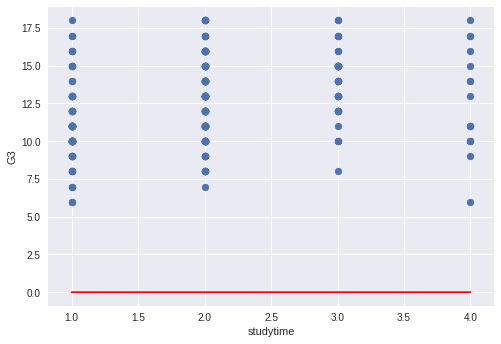

In [38]:
# Get the min and max total_rooms values.
x_0 = sample["studytime"].min()
x_1 = sample["studytime"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/studytime/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted G3 for the min and max studytime values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("G3")
plt.xlabel("studytime")

# Plot a scatter plot from our data sample.
plt.scatter(sample["studytime"], sample["G3"])

# Display graph.
plt.show()

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="studytime"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `Grades`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = data[[my_feature]]
  my_label = "G3"
  targets = data[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = data.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print ("Training model...")
  print ("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print ("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print ("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print ("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 11.42
  period 01 : 10.36
  period 02 : 9.32
  period 03 : 8.30
  period 04 : 7.33
  period 05 : 6.42
  period 06 : 5.60
  period 07 : 4.92
  period 08 : 4.46
  period 09 : 4.17
Model training finished.


,predictions,targets
count,633.000000,620.000000
mean,10.232263,12.193548
std,3.283566,2.642628
min,6.522081,5.000000
25%,6.522081,10.000000
50%,10.462593,12.000000
75%,10.462593,14.000000
max,18.343616,19.000000


Final RMSE (on training data): 4.17


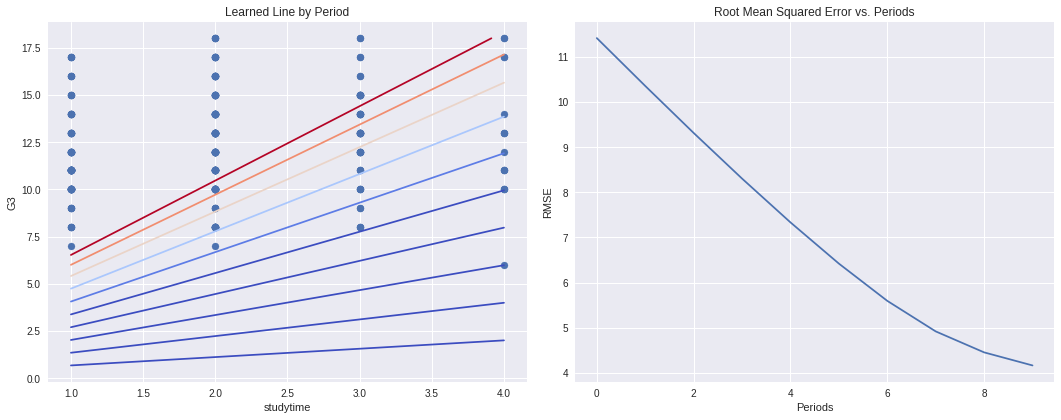

In [56]:
train_model(
    learning_rate=0.002,
    steps=500,
    batch_size=5
)